In [7]:
from simple_pid import PID

In [114]:

def simulation(pid_params, duration_m=60*12, init_OD=1.0, hourly_growth_rate=0.08, target=None, volume=2):
    pid = PID(*pid_params, output_limits=(0, 1), sample_time=None)
    pid.setpoint = target
    OD_state = []
    OD = init_OD
    
    for i in range(duration_m):
        OD *= np.exp(hourly_growth_rate / 60)
        
        if (i % 30 == 0) and i > 0:
            output = pid(OD, dt=30)
            OD *= (1-(output * volume ) / 14)
            
    
        OD_state.append(OD)

    return OD_state

def score(OD_state, target):
    return ((np.array([OD_state[i] for i in 30 * np.arange(1, int(len(OD_state)/30) ) - 1]) - target)**2).sum()


def simulate_and_score(pid_params, duration_m=60*12, init_OD=1.0, hourly_growth_rate=0.08, target=None,  volume=2):
    return 100 * score(simulation(pid_params, duration_m, init_OD, hourly_growth_rate, target, volume), target)


In [115]:
from autograd import grad

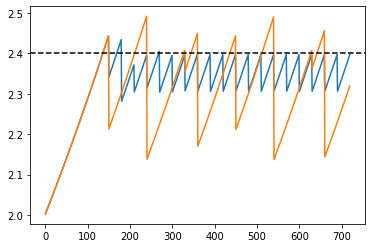

In [116]:
duration_m = 60 * 12
setpoint = 2.4
init_OD = 2.
volume=2
t = np.arange(duration_m)


y = simulation([-2, -0.15, -0], duration_m, target=setpoint, init_OD=init_OD, volume=volume)
plt.plot(t, y)


y = simulation([-10, -0.15, -0], duration_m, target=setpoint, init_OD=init_OD, volume=volume)
plt.plot(t, y)

plt.axhline(setpoint, c="k", ls="--")

In [117]:
from scipy.optimize import minimize, basinhopping

In [184]:
duration_m = 60 * 24
setpoint = 2.5
init_OD = 3.
volume=2.0
hourly_growth_rate=0.1

def mc_score(params):
    running_sum = 0
    N = 4000
    for i in range(N):
        init_OD = 2 * np.random.random() + 1
        setpoint =  1.5 * np.random.random() + 1
        volume = 2
        hourly_growth_rate = 0.2 * np.random.random() + 0.05
        v = simulate_and_score(params, duration_m, init_OD, hourly_growth_rate, setpoint, volume)
        running_sum += v
    return running_sum / N

mc_score((-2, 0.15, 0.1))

556.5220073808414

In [185]:
results = minimize(
    mc_score,
    x0 = [-2, -0.15, -.5],
    bounds=[(None, 0), (None, 0), (None, 0)],
    options={'disp': 2},
    method="L-BFGS-B"
)

0.5967427104161553
1.0969447677346493
0.5973966642623246


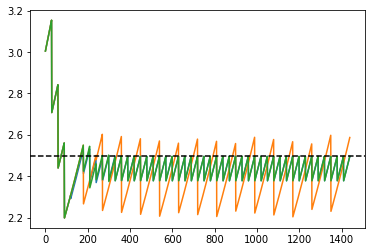

In [138]:
t = np.arange(duration_m)


y = simulation([-2, -0.10, -0], duration_m, target=setpoint, init_OD=init_OD,hourly_growth_rate=hourly_growth_rate, volume=volume)
print(score(y, setpoint))
plt.plot(t, y)


y = simulation([-10, -0.15, -0], duration_m, target=setpoint, init_OD=init_OD, hourly_growth_rate=hourly_growth_rate, volume=volume)
print(score(y, setpoint))
plt.plot(t, y)

y = simulation(results.x, duration_m, target=setpoint, init_OD=init_OD,hourly_growth_rate=hourly_growth_rate, volume=volume)
print(score(y, setpoint))

plt.plot(t, y)

plt.axhline(setpoint, c="k", ls="--")

4575.784273319217

In [186]:
results.x

array([-1.99999933, -0.15000579, -0.49999932])